In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import math
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn import preprocessing
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import random 
random.seed(33)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

/home/dsc/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dsc/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
listings = pd.read_csv('../Data/listings_cleanTotal.csv')

In [4]:
performance2017 = pd.read_excel('../Data/Performance Approach V0.xls')
columns_to_keep = ['id', 'Published_Before_2017', '2017_Total_Income_Est','2017_Total_Number_Reviews']
performance2017 = performance2017[columns_to_keep]

In [5]:
listingsPerformance = pd.concat([listings, performance2017], axis=1, join='inner')

In [6]:
#We remove listings that didn't have performance or have no availability in 2018 as it might mean that they are not really available for booking
listingsPerfClean = listingsPerformance[(listingsPerformance['Published_Before_2017']=='yes') & (listingsPerformance['2017_Total_Number_Reviews']!=0) & (listingsPerformance['availability_365']!=0)]

In [9]:
listingsPerfClean.shape

(9058, 48)

(array([ 767.,  816.,  908.,  532.,  927.,  396.,  481.,  693., 1012.,
        2526.]),
 array([  1. ,  37.4,  73.8, 110.2, 146.6, 183. , 219.4, 255.8, 292.2,
        328.6, 365. ]),
 <a list of 10 Patch objects>)

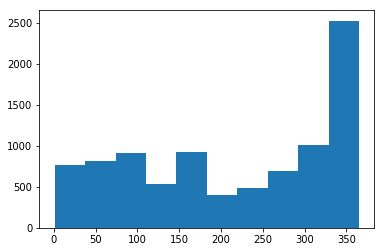

In [8]:
plt.hist(listingsPerfClean['availability_365'])

In [10]:
numerical_features = ['latitude', 'longitude', 'accommodates', 'bathrooms','bedrooms', 'minimum_nights',
                      'review_scores_value','price','2017_Total_Number_Reviews']
boolean_features = ['instant_bookable', 'is_business_travel_ready', 'Parking', 'Wifi']
categorical_features = ['property_type', 'cancellation_policy']
listings_categorical = pd.get_dummies(listingsPerfClean[categorical_features], columns=categorical_features, 
                                        prefix=["Property", "CancPol"])
listingsPerfClean2 = pd.concat([listingsPerfClean['room_type'],listingsPerfClean[numerical_features],
                              listings_categorical,listingsPerfClean[boolean_features]], axis=1)

In [11]:
listingsHome = listingsPerfClean2[listingsPerfClean2['room_type']=='Entire home/apt'].drop(['room_type'],axis=1)
listingsRoom = listingsPerfClean2[listingsPerfClean2['room_type']=='Private room'].drop(['room_type'],axis=1)
listingsSharedRoom = listingsPerfClean2[listingsPerfClean2['room_type']=='Shared room'].drop(['room_type'],axis=1)

/home/dsc/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


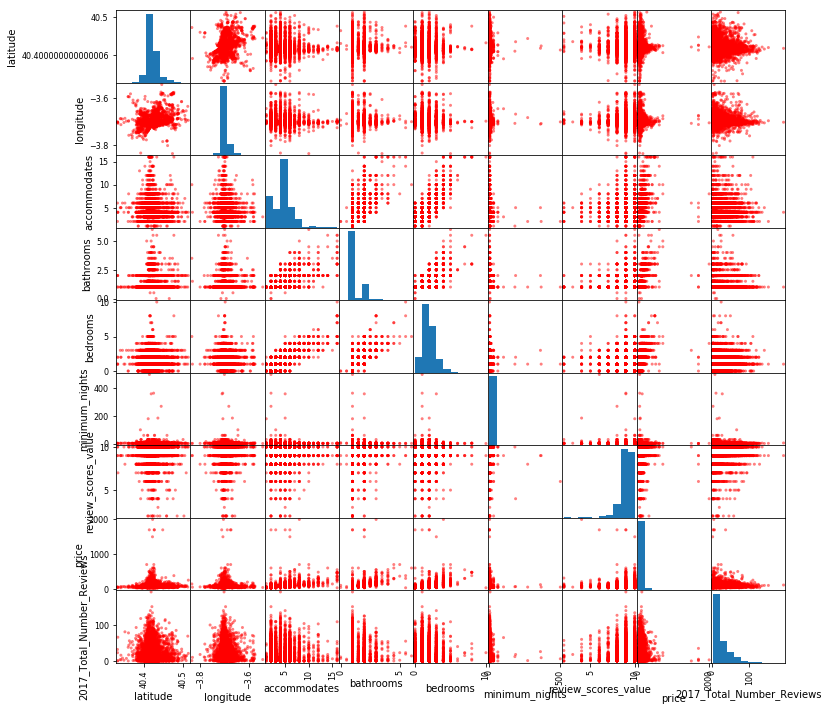

In [12]:
axs = pd.scatter_matrix(listingsHome[numerical_features],
                        figsize=(12, 12), c='red')

Accommodates, bathrooms and bedrooms seem to be the only features with a "clear" positive correlation

We study deeper minimum nights and price, as they seem to have some outliers that are distorting the sample

In [13]:
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,Property_Apartment,...,Property_Vacation home,Property_Villa,CancPol_flexible,CancPol_moderate,CancPol_strict,CancPol_super_strict_30,instant_bookable,is_business_travel_ready,Parking,Wifi
count,6079.000000,6079.000000,6079.00000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,...,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,40.419911,-3.698686,4.21237,1.260322,1.495147,2.978121,9.221911,88.598783,21.098865,0.886659,...,0.006087,0.000494,0.178977,0.371278,0.431650,0.018095,0.576740,0.065800,0.000658,0.966935
std,0.016191,0.018319,1.95637,0.522100,0.967012,10.863766,0.937294,74.604806,22.334638,0.317035,...,0.077785,0.022211,0.383364,0.483186,0.495347,0.133306,0.494117,0.247953,0.025645,0.178820
min,40.332908,-3.835498,1.00000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410834,-3.707186,3.00000,1.000000,1.000000,2.000000,9.000000,56.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417518,-3.701954,4.00000,1.000000,1.000000,2.000000,9.000000,74.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425289,-3.696230,5.00000,1.000000,2.000000,3.000000,10.000000,100.000000,31.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,40.512476,-3.543342,16.00000,6.000000,10.000000,500.000000,10.000000,2000.000000,193.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
#We remove outliers manually trying to see if there is correlation between variables
p98 = np.percentile(listingsHome['minimum_nights'], 98)
listingsHome = listingsHome[listingsHome['minimum_nights']<=p98]
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,Property_Apartment,...,Property_Vacation home,Property_Villa,CancPol_flexible,CancPol_moderate,CancPol_strict,CancPol_super_strict_30,instant_bookable,is_business_travel_ready,Parking,Wifi
count,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,...,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000
mean,40.419852,-3.698676,4.225243,1.261329,1.496475,2.295737,9.227425,88.679758,21.111950,0.885196,...,0.006210,0.000504,0.179590,0.371433,0.430514,0.018463,0.584256,0.066465,0.000671,0.966767
std,0.016111,0.018267,1.964419,0.523513,0.969696,1.166291,0.922081,74.763751,22.366483,0.318812,...,0.078566,0.022436,0.383878,0.483229,0.495190,0.134628,0.492891,0.249115,0.025904,0.179259
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410846,-3.707151,3.000000,1.000000,1.000000,2.000000,9.000000,56.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417414,-3.701951,4.000000,1.000000,1.000000,2.000000,9.000000,74.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425210,-3.696273,5.000000,1.000000,2.000000,3.000000,10.000000,100.000000,31.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,40.512476,-3.543342,16.000000,6.000000,10.000000,8.000000,10.000000,2000.000000,193.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
p98 = np.percentile(listingsHome['price'], 98)
listingsHome = listingsHome[listingsHome['price']<=p98]
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,Property_Apartment,...,Property_Vacation home,Property_Villa,CancPol_flexible,CancPol_moderate,CancPol_strict,CancPol_super_strict_30,instant_bookable,is_business_travel_ready,Parking,Wifi
count,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,40.419821,-3.698631,4.137500,1.232791,1.454281,2.297945,9.225171,81.986644,21.153596,0.885616,...,0.006164,0.000342,0.180822,0.374315,0.426027,0.018836,0.585959,0.066096,0.000514,0.966267
std,0.016174,0.018392,1.788844,0.465043,0.904385,1.168430,0.919699,37.149663,22.382219,0.318304,...,0.078278,0.018504,0.384904,0.483987,0.494540,0.135956,0.492598,0.248471,0.022661,0.180556
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410763,-3.707141,3.000000,1.000000,1.000000,2.000000,9.000000,55.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417307,-3.701953,4.000000,1.000000,1.000000,2.000000,9.000000,72.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425230,-3.696259,5.000000,1.000000,2.000000,3.000000,10.000000,99.000000,31.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,40.511100,-3.543342,16.000000,5.500000,10.000000,8.000000,10.000000,240.000000,193.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
listingsHome = listingsHome[listingsHome['accommodates']<=10]
listingsHome.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,minimum_nights,review_scores_value,price,2017_Total_Number_Reviews,Property_Apartment,...,Property_Vacation home,Property_Villa,CancPol_flexible,CancPol_moderate,CancPol_strict,CancPol_super_strict_30,instant_bookable,is_business_travel_ready,Parking,Wifi
count,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,...,5798.000000,5798.000000,5798.000000,5798.00000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000
mean,40.419841,-3.698613,4.077613,1.225164,1.434633,2.300448,9.226112,81.521904,21.142118,0.887030,...,0.005692,0.000172,0.181787,0.37375,0.425492,0.018972,0.585547,0.066057,0.000517,0.966023
std,0.016191,0.018353,1.646899,0.453514,0.870493,1.169934,0.921310,36.655840,22.363738,0.316583,...,0.075234,0.013133,0.385702,0.48384,0.494460,0.136438,0.492670,0.248404,0.022743,0.181186
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,2.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.410755,-3.707125,3.000000,1.000000,1.000000,2.000000,9.000000,55.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,40.417356,-3.701937,4.000000,1.000000,1.000000,2.000000,9.000000,71.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,40.425277,-3.696227,5.000000,1.000000,2.000000,3.000000,10.000000,98.000000,31.000000,1.000000,...,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,40.511100,-3.543342,10.000000,4.000000,5.000000,8.000000,10.000000,240.000000,193.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
#We modify latitude and longitude measuring the axis distance to "Puerta del Sol"
listingsHome['latitude'] = abs(listingsHome['latitude']- 40.41694)
listingsHome['longitude'] = abs(listingsHome['longitude'] -(-3.70361))

/home/dsc/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


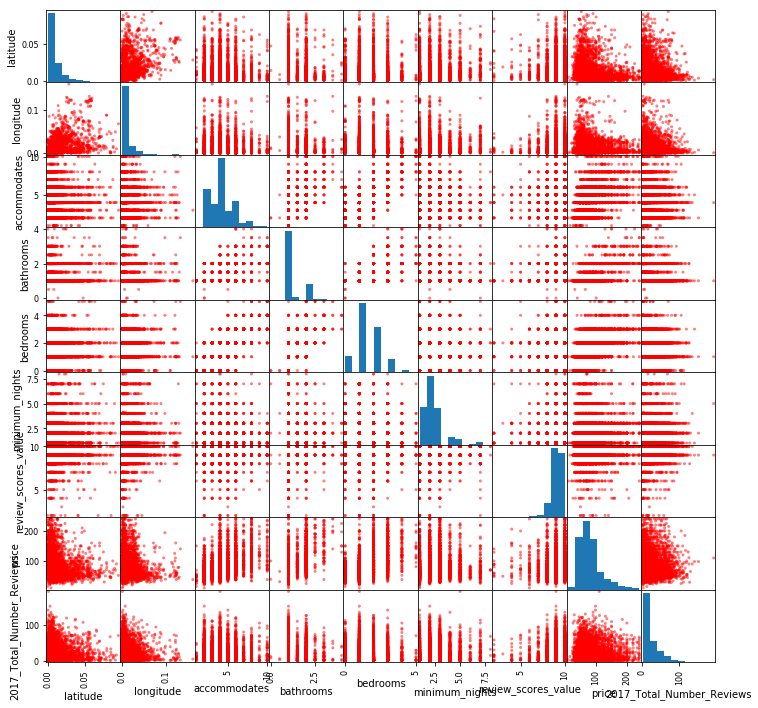

In [19]:
axs = pd.scatter_matrix(listingsHome[numerical_features],
                        figsize=(12, 12), c='red')

In [20]:
#We keep only the variables that seemed to be more correlated with the total number of reviews in the previous trials
X = listingsHome.loc[:,['price', 'review_scores_value', 'accommodates','latitude', 'longitude']]
y = listingsHome['2017_Total_Number_Reviews']
y = y.reshape(-1,1)

/home/dsc/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [21]:
X.columns

Index(['price', 'review_scores_value', 'accommodates', 'latitude',
       'longitude'],
      dtype='object')

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.25,
                            random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4348, 5)
(1450, 5)
(4348, 1)
(1450, 1)


In [23]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

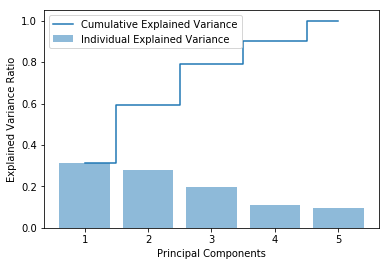

['price', 'review_scores_value', 'longitude', 'latitude', 'accommodates']


In [24]:
cov_X = np.cov(X_train.T) # Construct the covariance matrix.
eigen_vals, eigen_vecs = np.linalg.eig(cov_X) #Decompose the covariance matrix into its eigenvectors and eigenvalues.

import matplotlib.pyplot as plt
sorted_eigen_vals = sorted(eigen_vals, reverse = True)
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted_eigen_vals]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,len(var_exp)+1), var_exp, alpha = 0.5, align = 'center',
        label = 'Individual Explained Variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid',
        label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()
pca = []
for i in range(0,5) :
    #print(str(i+1) + ' principal component is:' + str(X.columns.values[np.where(eigen_vals==sorted_eigen_vals[i])]))
    pca.extend(X.columns.values[np.where(eigen_vals==sorted_eigen_vals[i])])
print(pca)
X = X[pca]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.25,
                            random_state=0)
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

In [26]:
print(np.max(y_train), np.min(y_train), np.mean(y_train))
print(np.max(y_test), np.min(y_test), np.mean(y_test))

4.815608403156044 -0.9063370227668679 8.170914624656166e-17
7.744163148707139 -0.9063370227668679 0.0046377043425968704


In [27]:
def train_and_validate(method_name, slr, X_train,y_train, X_test, y_test):
    slr.fit(X_train,y_train)
    y_train_pred = slr.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    y_test_pred = slr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print('Method: %s' %method_name)
    print('MSE on training: %.3f' %mse_train)
    print('r^2 on training: %.3f' %r2_train)
    print('MSE on test: %.3f' %mse_test)
    print('r^2 on test: %.3f' %r2_test)
    
    return y_test_pred

In [28]:
from sklearn.linear_model import SGDRegressor
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Compute MSE on training data
sgdreg = SGDRegressor(loss='squared_loss', penalty=None,  random_state=10)

method_name = 'Stochastic Gradient Descent Regression'
y_test_pred = train_and_validate(method_name, sgdreg, X_train,y_train, X_test, y_test)

Method: Stochastic Gradient Descent Regression
MSE on training: 1.001
r^2 on training: -0.001
MSE on test: 1.059
r^2 on test: 0.001


In [29]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0.05, l1_ratio=0.1)
y_test_pred = train_and_validate("Elastic Net", enet, X_train,y_train, X_test, y_test)

Method: Elastic Net
MSE on training: 1.000
r^2 on training: 0.000
MSE on test: 1.060
r^2 on test: 0.000


In [30]:
from sklearn import svm
slr_svr = svm.SVR(kernel='linear')
y_test_pred = train_and_validate("Support Vector Machine", slr_svr, X_train,y_train, X_test, y_test)

Method: Support Vector Machine
MSE on training: 1.139
r^2 on training: -0.139
MSE on test: 1.201
r^2 on test: -0.133


In [31]:
from sklearn.svm import SVR
slr_svr_rbf_1 = SVR(kernel='rbf', C=1)
y_test_pred_1 = train_and_validate("Support Vector Machine RBF", slr_svr_rbf_1, X_train,y_train, X_test, y_test)
slr_svr_rbf_2 = SVR(kernel='rbf', C=10)
y_test_pred_2 = train_and_validate("Support Vector Machine RBF", slr_svr_rbf_2, X_train,y_train, X_test, y_test)

Method: Support Vector Machine RBF
MSE on training: 1.083
r^2 on training: -0.083
MSE on test: 1.202
r^2 on test: -0.133
Method: Support Vector Machine RBF
MSE on training: 1.040
r^2 on training: -0.040
MSE on test: 1.259
r^2 on test: -0.187


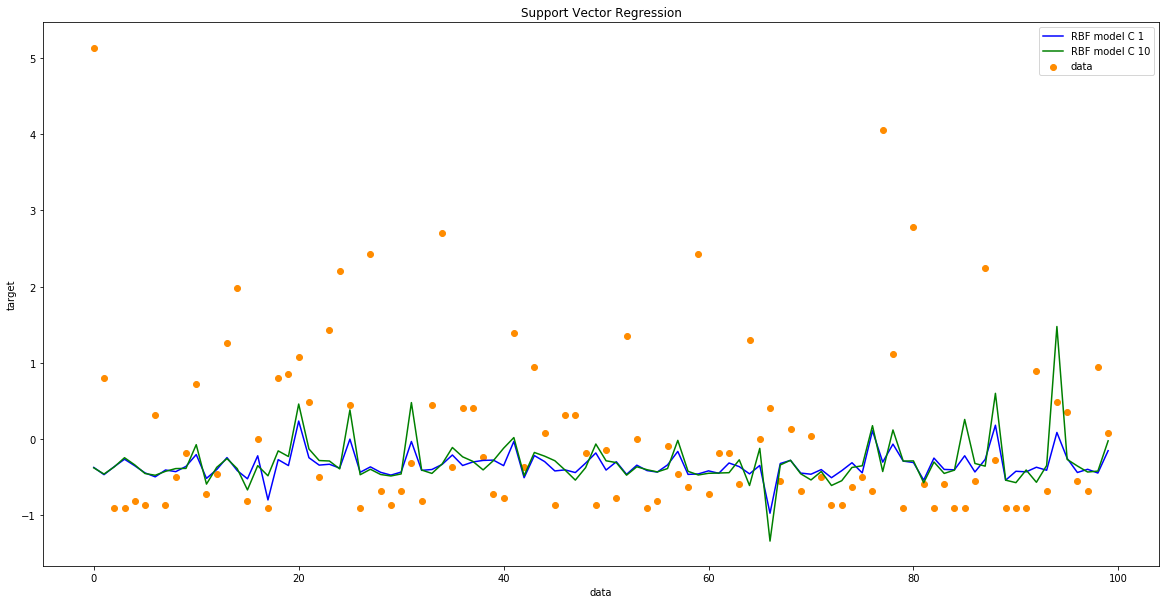

In [32]:
lw = 2
plt.scatter(range(0, 100), y_test[0:100], color='darkorange', label='data')
plt.hold('on')
plt.plot(range(0, 100), y_test_pred_1[0:100], color='b',label='RBF model C 1')
plt.plot(range(0, 100), y_test_pred_2[0:100], color='g',label='RBF model C 10')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [33]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(50,10,), max_iter=1000, learning_rate = 'adaptive')
y_test_pred = train_and_validate("Multi-layer Perceptron regressor", mlp, X_train,y_train, X_test, y_test)

Method: Multi-layer Perceptron regressor
MSE on training: 0.982
r^2 on training: 0.018
MSE on test: 1.060
r^2 on test: -0.000


In [34]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 180, 
          'max_depth': 1, 
          'min_samples_split': 2,
          'learning_rate': 0.2, 
          'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)

gbr.fit(X_train, y_train)
y_pred_gbr = train_and_validate("forward stage-wise", gbr, X_train,y_train, X_test, y_test)

Method: forward stage-wise
MSE on training: 0.978
r^2 on training: 0.022
MSE on test: 1.057
r^2 on test: 0.003


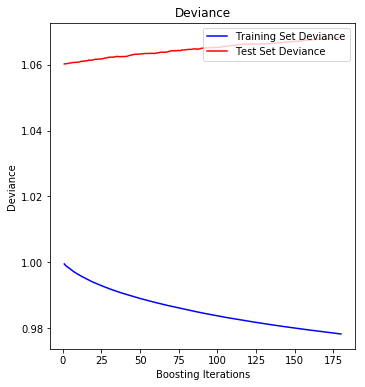

In [35]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

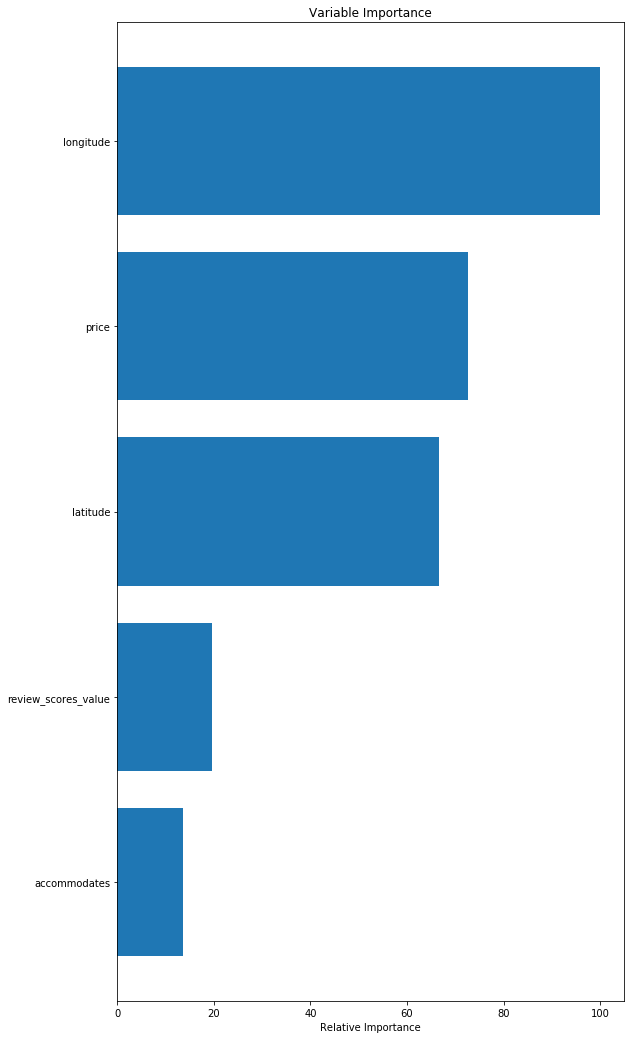

In [36]:
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
fig = plt.gcf()
fig.set_size_inches(20, 18)
plt.show()

Automatically created module for IPython interactive environment


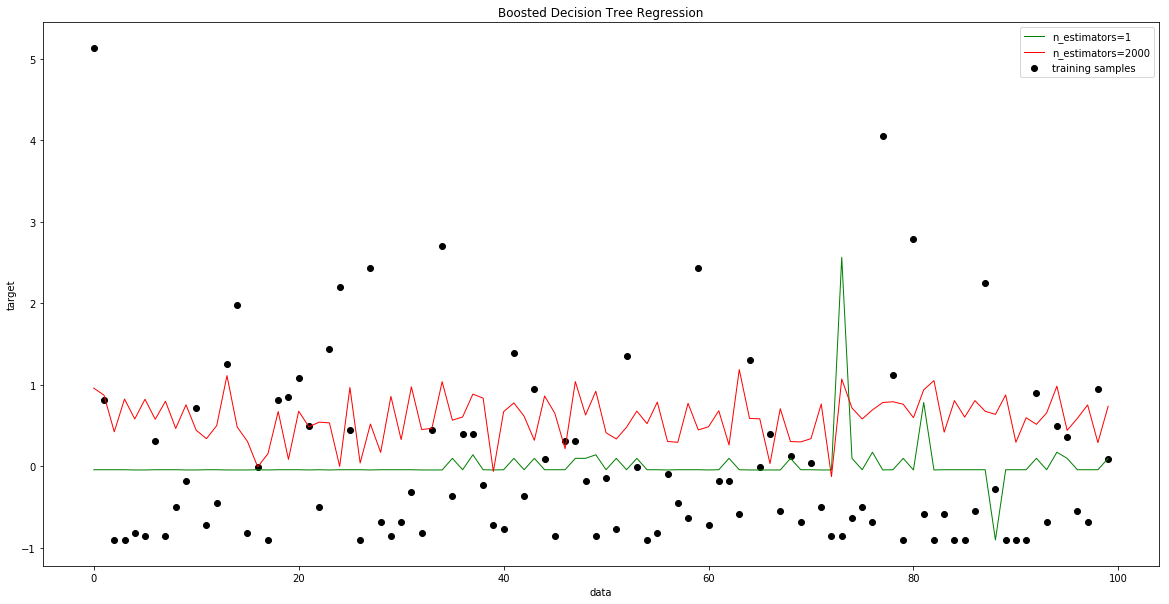

In [37]:
print(__doc__)

# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),
                          n_estimators=2000, random_state=0)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(range(0,100), y_test[0:100], c="k", label="training samples")
plt.plot(range(0,100), y_1[0:100], c="g", label="n_estimators=1", linewidth=1)
plt.plot(range(0,100), y_2[0:100], c="r", label="n_estimators=2000", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()